## Preparation
What does an input and its label look like?

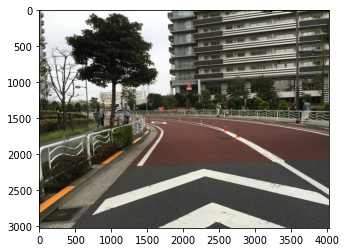

Shape: (3024, 4032, 3)


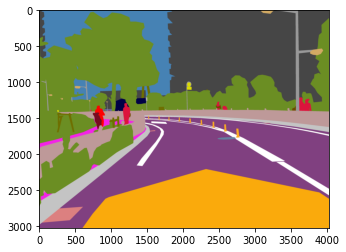

Shape: (3024, 4032, 3)


In [3]:
import os
from keras import utils
import matplotlib.pyplot as plt

def get_first(my_dir):
    file_name = os.listdir(my_dir)[0]
    image = utils.load_img(os.path.join(my_dir, file_name))
    return image

def show_first(my_dir):
    image = get_first(my_dir)
    image = utils.img_to_array(image)
    image /= 255
    
    plt.imshow(image)
    plt.show()
    print('Shape: ' + str(image.shape))

train_x_src_dir = 'data/training/images'
train_y_src_dir = 'data/training/v2.0/labels'

show_first(train_x_src_dir)
show_first(train_y_src_dir)

Make the file structure:

In [1]:
import shutil

base_dir = 'data_small'

def rm_dir(my_dir):
    if os.path.exists(my_dir):
        shutil.rmtree(my_dir)

rm_dir(base_dir)

def make_dir(my_dir):
    if not os.path.exists(my_dir):
        os.mkdir(my_dir)

make_dir(base_dir)

def sub_dir(base_dir, sub_dir):
    sub_dir = os.path.join(base_dir, sub_dir)
    make_dir(sub_dir)
    return sub_dir

train_dir = sub_dir(base_dir, 'train')
train_x_dir = sub_dir(train_dir, 'x')
train_y_dir = sub_dir(train_dir, 'y')

val_dir = sub_dir(base_dir, 'val')
val_x_dir = sub_dir(val_dir, 'x')
val_y_dir = sub_dir(val_dir, 'y')

test_dir = sub_dir(base_dir, 'test')

Copy over some images. Our x's are images, while our y's are labels:

In [2]:
import random

total_size = 1000
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)

file_names = random.sample(os.listdir('data/training/images'), train_size)

def clear_dir(my_dir):
    file_names = os.listdir(my_dir)
    
    for file_name in file_names:
        os.remove(os.path.join(my_dir, file_name))

def copy_files(src_dir, dest_dir, file_names):
    for file_name in file_names:
        shutil.copy(os.path.join(src_dir, file_name), dest_dir)

clear_dir(train_x_dir)
copy_files('data/training/images', train_x_dir, file_names)

def set_ext(file_name, ext):
    return os.path.splitext(file_name)[0] + ext

clear_dir(train_y_dir)
copy_files('data/training/v2.0/labels', train_y_dir, list(map(lambda x : set_ext(x, '.png'), file_names)))

file_names = random.sample(os.listdir('data/validation/images'), val_size)
clear_dir(val_x_dir)
copy_files('data/validation/images', val_x_dir, file_names)
clear_dir(val_y_dir)
copy_files('data/validation/v2.0/labels', val_y_dir, list(map(lambda x : set_ext(x, '.png'), file_names)))

file_names = random.sample(os.listdir('data/testing/images'), test_size)
clear_dir(test_dir)
copy_files('data/testing/images', test_dir, file_names)

What does an input and its label look like? Let's convert them into tensors and display them:

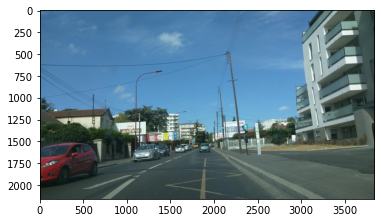

Shape: (2160, 3840, 3)


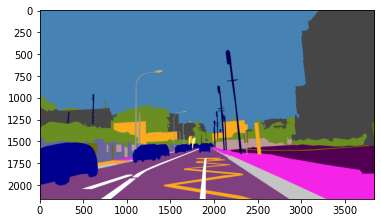

Shape: (2160, 3840, 3)


In [3]:
# from keras import utils
# import matplotlib.pyplot as plt

# def get_first(my_dir):
#     file_name = os.listdir(my_dir)[0]
#     image = utils.load_img(os.path.join(my_dir, file_name))
#     return image

# def show_first(my_dir):
#     image = get_first(my_dir)
#     image = utils.img_to_array(image)
#     image /= 255
    
#     plt.imshow(image)
#     plt.show()
#     print('Shape: ' + str(image.shape))

# show_first(train_x_dir)
# show_first(train_y_dir)

## Encoding

Let's integer-encode the categories of a label:

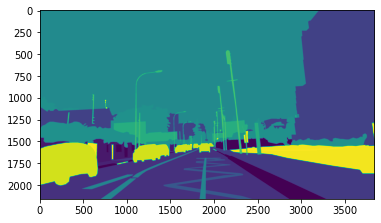

In [13]:
import json
import numpy as np
from keras import layers
import tensorflow as tf

fig_width = 7.5

config_file = open('data/config_v2.0.json')
config = json.load(config_file)
cats_to_colors = list(map(lambda x: x['color'], config['labels']))

# def to_cats(colors, input_width, input_height):

def to_cats(colors):
#     print(colors)
    cats = np.zeros((colors.shape[-3], colors.shape[-2]))
    
    for i in range(len(cats_to_colors)):
        color = cats_to_colors[i]
        mask = np.all(label == color, axis=-1)
        cats[mask] = i
    
    return cats.astype(int)

label = get_first(train_y_dir)
label = utils.img_to_array(label)
label = to_cats(label)

# fig, ax = plt.subplots(figsize=(fig_width, fig_width * label.shape[0] / label.shape[1]))
# ax.imshow(label)
plt.imshow(label)
plt.show()

## Naive Autoencoder

In [17]:
from keras import models
from keras import optimizers
from keras import backend

input_width = 512
input_height = 512
input_shape = (input_width, input_height, 3)
num_f_maps_0 = 8

encoder = models.Sequential()
encoder.add(layers.Conv2D(num_f_maps_0, kernel_size=3, padding='same', activation='relu', input_shape=(input_shape)))
encoder.add(layers.MaxPool2D(pool_size=2))
encoder.add(layers.Conv2D(num_f_maps_0 * 2, kernel_size=3, padding='same', activation='relu'))
encoder.add(layers.MaxPool2D(pool_size=2))
encoder.add(layers.Conv2D(num_f_maps_0 * 4, kernel_size=3, padding='same', activation='relu'))
encoder.add(layers.MaxPool2D(pool_size=2))

decoder = models.Sequential()

decoder.add(layers.Conv2DTranspose(
    num_f_maps_0 * 2,
    kernel_size=3,
    strides=2,
    padding='same',
    activation='relu',
    input_shape=(input_width // 8, input_height // 8, num_f_maps_0 * 4)))

decoder.add(layers.Conv2DTranspose(num_f_maps_0, kernel_size=3, strides=2, padding='same', activation='relu'))
decoder.add(layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='softmax'))

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam())
autoencoder.summary()
backend.clear_session()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 32)        6032      
                                                                 
 sequential_1 (Sequential)   (None, 512, 512, 1)       5857      
                                                                 
Total params: 11,889
Trainable params: 11,889
Non-trainable params: 0
_________________________________________________________________


Let's start training:

In [18]:
batch_size = 20
num_epochs = 16
normalizer = layers.Rescaling(1./255)

train_x_dataset = utils.image_dataset_from_directory(
    train_x_dir,
    labels=None,
    batch_size=batch_size,
    image_size=(input_height, input_width),
    shuffle=False
)

train_x_dataset = train_x_dataset.map(lambda x: normalizer(x))

train_y_dataset = utils.image_dataset_from_directory(
    train_y_dir,
    labels=None,
    batch_size=batch_size,
    image_size=(input_height, input_width),
    shuffle=False,
    interpolation='nearest'
)

train_y_dataset = train_y_dataset.map(lambda x: to_cats(x))

train_gen = zip(train_x_dataset.repeat(), train_y_dataset.repeat())

val_x_dataset = utils.image_dataset_from_directory(
    val_x_dir,
    labels=None,
    batch_size=batch_size,
    image_size=(input_height, input_width),
    shuffle=False
)

val_x_dataset = val_x_dataset.map(lambda x: normalizer(x))

val_y_dataset = utils.image_dataset_from_directory(
    train_y_dir,
    labels=None,
    batch_size=batch_size,
    image_size=(input_height, input_width),
    shuffle=False,
    interpolation='nearest'
)

val_y_dataset = val_y_dataset.map(lambda x: to_cats(x))

val_gen = zip(val_x_dataset.repeat(), val_y_dataset.repeat())

history = autoencoder.fit(
    train_gen,
    steps_per_epoch=train_size//batch_size,
    epochs=num_epochs,
    validation_data=val_gen,
    validation_steps=val_size//batch_size
)

Found 800 files belonging to 1 classes.
Found 800 files belonging to 1 classes.
Found 100 files belonging to 1 classes.


C:\Users\Lenny\AppData\Local\Temp\__autograph_generated_filetligfjg6.py:21: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mask = ag__.converted_call(ag__.ld(np).all, (ag__.ld(label) == ag__.ld(color),), dict(axis=-1), fscope)


Found 800 files belonging to 1 classes.
Epoch 1/16


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Lenny\AppData\Local\Temp\ipykernel_11072\15414066.py", line 51, in <cell line: 51>
      history = autoencoder.fit(
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\engine\training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\losses.py", line 1860, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\Lenny\anaconda3\envs\cscis89\lib\site-packages\keras\backend.py", line 5238, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [5242880,1] and labels shape [262144]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_3395]

How do predicted labels on validation inputs compare to actual labels?

In [ ]:
import matplotlib.pyplot as plt
num_images = 5
fig_width = 12

predictions = autoencoder.predict(val_x_dataset)
batch = list(val_y_dataset.take(1))[0]
figure, axes = plt.subplots(num_images, 2, figsize=(fig_width, fig_width / 2 * num_images))
indices = random.sample(range(batch_size), num_images)

for i in range(num_images):
    axes[i][0].imshow(batch[indices[i]])
    axes[i][0].set_aspect('auto')
    axes[i][1].imshow(predictions[indices[i]])
    axes[i][1].set_aspect('auto')

plt.show()

What do predictions on test inputs look like?

In [ ]:
test_dataset = get_dataset(test_dir)
predictions = autoencoder.predict(test_dataset)
batch = list(test_dataset.take(1))[0]
figure, axes = plt.subplots(num_images, 2, figsize=(fig_width, fig_width / 2 * num_images))
indices = random.sample(range(batch_size), 5)

for data in dataset:
    for i in range(num_images):
        axes[i][0].imshow(data[indices[i]])
        axes[i][0].set_aspect('auto')
        axes[i][1].imshow(predictions[indices[i]])
        axes[i][1].set_aspect('auto')

plt.show()